In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

Using device: cuda
Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [2]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

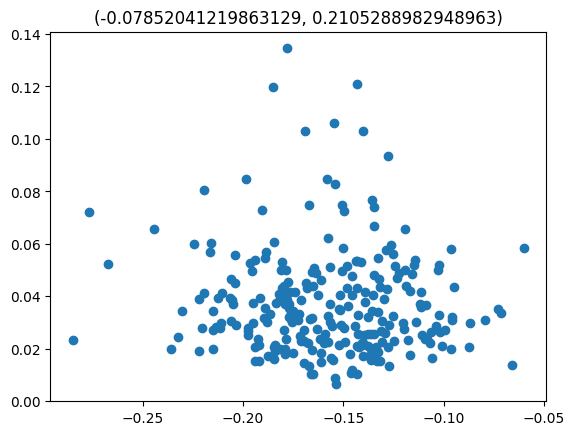

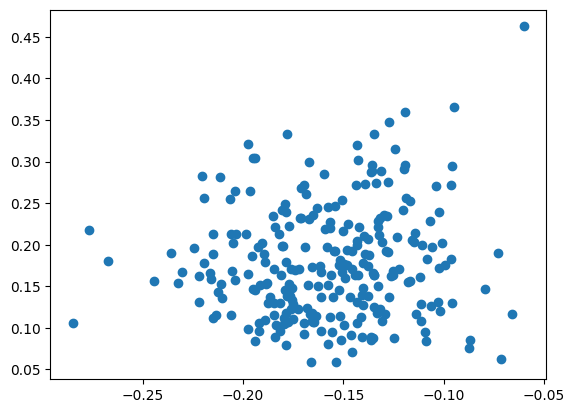

In [99]:
plt.scatter(
    -results['layer1']['monosemanticity'],
    results['layer1']['kmeans_256'].cluster_centers_.mean(0)
)
plt.title(corr(
    -results['layer1']['monosemanticity'],
    results['layer1']['kmeans_256'].cluster_centers_.mean(0)
))
plt.show()

plt.scatter(
    -results['layer1']['monosemanticity'],
    results['layer1']['kmeans_256'].cluster_centers_.max(0)
)
plt.show()

(array([174.,  50.,  20.,   6.,   2.,   1.,   0.,   0.,   1.,   2.]),
 array([0.00157224, 0.02133892, 0.04110559, 0.06087227, 0.08063895,
        0.10040562, 0.1201723 , 0.13993897, 0.15970565, 0.17947233,
        0.199239  ], dtype=float32),
 <BarContainer object of 10 artists>)

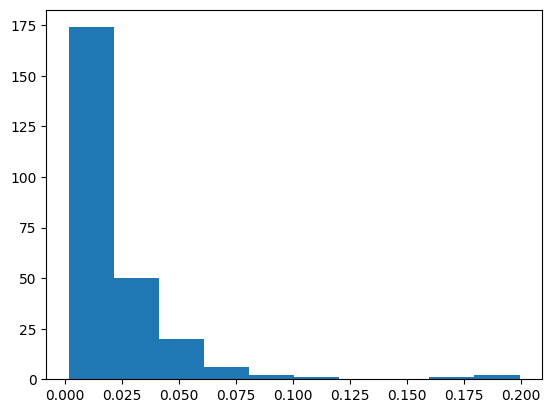

In [102]:
plt.hist(results['layer1']['kmeans_256'].cluster_centers_[:, 0])

In [79]:
#km = MiniBatchKMeans(256).fit(results['layer1']['activations'])
km = results['layer1']['kmeans_256']

In [48]:
km.cluster_centers_.shape

(256, 256)

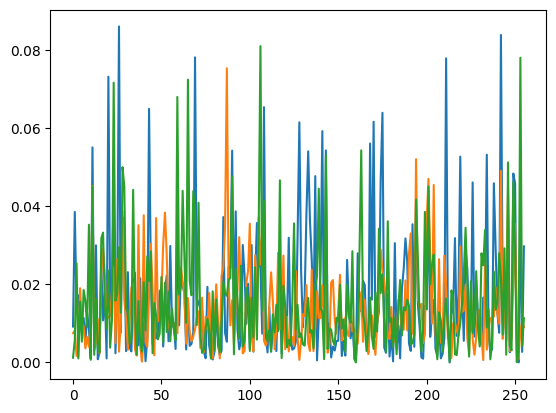

In [49]:
plt.plot(km.cluster_centers_[:3].T)

In [80]:
cluster_centers_orig = km.cluster_centers_.copy()
#data = results['layer1']['activations'].copy()
data = results['layer1']['activations_normed'].copy()
labels = km.predict(data)

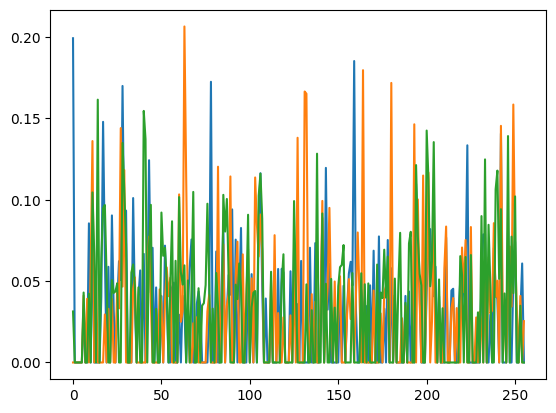

In [81]:
# Radically sparsify
cluster_centers = cluster_centers_orig.copy()
for i in range(cluster_centers.shape[0]):
    ind = cluster_centers[i] < np.quantile(cluster_centers[i], .5)
    cluster_centers[i, ind] *= 0

plt.plot(cluster_centers[:3].T)

In [82]:
km.cluster_centers_ = cluster_centers
labels_ = km.predict(data)

In [83]:
np.mean(labels == labels_)

0.9313

In [84]:
km.cluster_centers_ = cluster_centers_orig.copy()
labels_ = km.predict(data)
np.mean(labels == labels_)

1.0

In [85]:
quantiles = np.linspace(0, .99, 100)
acc = []
for q in quantiles:
    cluster_centers = cluster_centers_orig.copy()
    for i in range(cluster_centers.shape[0]):
        ind = cluster_centers[i] < np.quantile(cluster_centers[i], q)
        cluster_centers[i, ind] *= 0
    km.cluster_centers_ = cluster_centers
    labels_ = km.predict(data)
    acc.append(np.mean(labels == labels_))
    km.cluster_centers_ = cluster_centers_orig.copy()

    


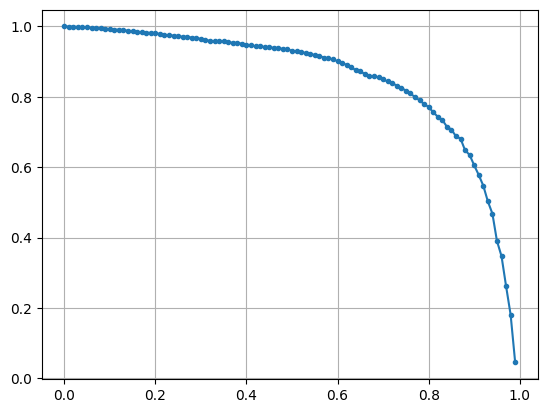

In [86]:
plt.plot(quantiles, acc, '.-')
plt.grid()

In [87]:
# top vs bottom
accs = []
for key in ['kmeans_256_top', 'kmeans_256_bottom']:
    activations_normed = results['layer1']['activations_normed'].copy()
    num_unit = activations_normed.shape[1]
    monosemanticity = results['layer1']['monosemanticity'].copy()
    ind_sort = np.argsort(monosemanticity)
    ind_top = ind_sort[:num_unit // 2]
    ind_bottom = ind_sort[num_unit // 2:]
    if key == 'kmeans_256_top':
        data = activations_normed[:, ind_top]
    else:
        data = activations_normed[:, ind_bottom]
    km = results['layer1'][key]
    cluster_centers_orig = km.cluster_centers_.copy()
    labels = km.predict(data)

    quantiles = np.linspace(0, .99, 100)
    acc = []
    for q in quantiles:
        cluster_centers = cluster_centers_orig.copy()
        for i in range(cluster_centers.shape[0]):
            ind = cluster_centers[i] < np.quantile(cluster_centers[i], q)
            cluster_centers[i, ind] *= 0
        km.cluster_centers_ = cluster_centers
        labels_ = km.predict(data)
        acc.append(np.mean(labels == labels_))
        km.cluster_centers_ = cluster_centers_orig.copy()
    accs.append(acc)


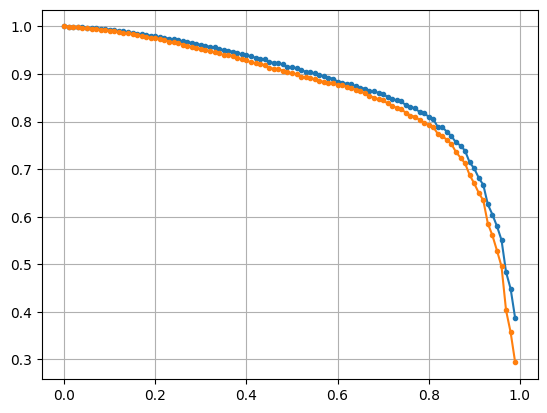

In [88]:
plt.plot(quantiles, accs[0], '.-')
plt.plot(quantiles, accs[1], '.-')
plt.grid()

In [57]:
labels_ = km.predict(data)
np.mean(labels == labels_)

1.0

In [66]:
# F1 per neuron
from sklearn.metrics import f1_score

quantiles = np.linspace(.1, .99, 20)
f1s = np.zeros((cluster_centers.shape[0], len(quantiles)))
accs = np.zeros((cluster_centers.shape[0], len(quantiles)))
for i in range(10):#cluster_centers.shape[0]):
    labels_unit = np.zeros_like(labels)
    labels_unit[labels == i] = 1
    for j, q in enumerate(quantiles):
        cluster_centers = cluster_centers_orig.copy()
        ind = cluster_centers[i] < np.quantile(cluster_centers[i], q)
        km.cluster_centers_[i, ind] *= 0
        labels_ = km.predict(data)
        labels_unit_ = np.zeros_like(labels_)
        labels_unit_[labels_ == i] = 1
        accs[i, j] = np.mean(labels_unit == labels_unit_)
        f1s[i, j] = f1_score(labels_unit, labels_unit_)
        km.cluster_centers_[i] = cluster_centers_orig[i].copy()

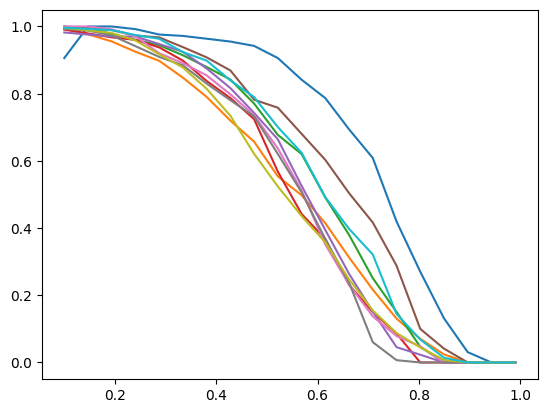

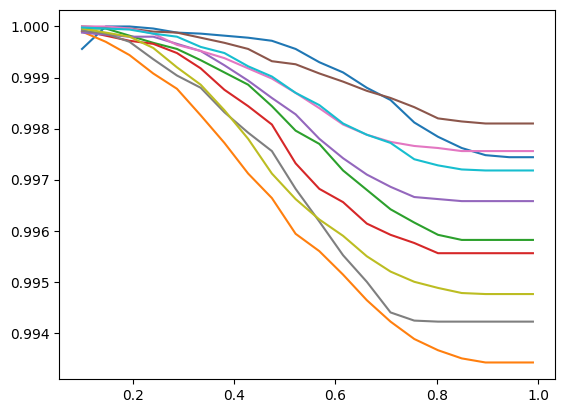

In [67]:
plt.plot(quantiles, f1s[:10].T)
plt.show()
plt.plot(quantiles, accs[:10].T)

In [77]:
scores = -results['layer1']['monosemanticity'].copy()
mi_weighted = cluster_centers_orig.copy()
mi_weighted -= mi_weighted.min(1)
mi_weighted /= mi_weighted.max(1)
mi_weighted = mi_weighted @ scores
mi_weighted.shape

(256,)

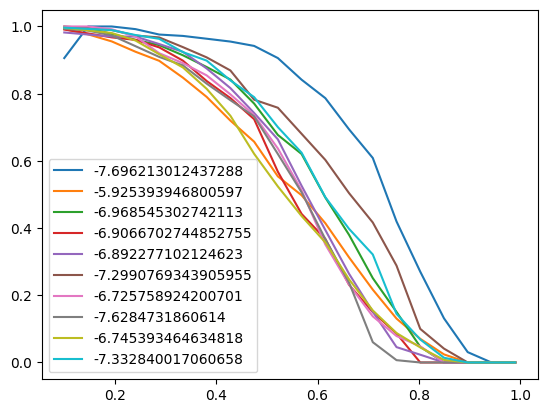

In [78]:
plt.plot(quantiles, f1s[:10].T)
plt.legend(mi_weighted[:10])

In [ ]:
# change centroids
i = 0
km.cluster_centers_[:, i] *= 0
labels_ = km.predict(data)
km.cluster_centers_ = cluster_centers.copy()  # restore


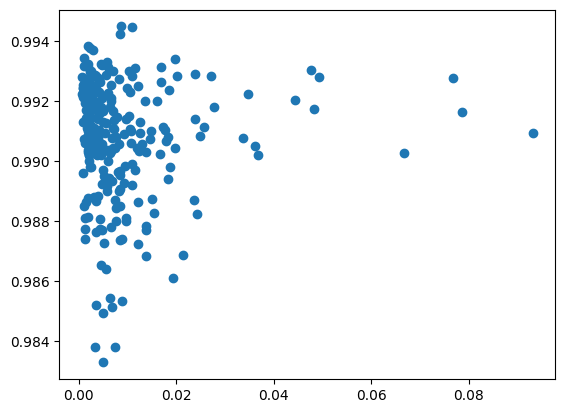

In [ ]:
change_per_cluster = []
for ind in range(cluster_centers.shape[0]):
    ind = labels == ind
    ind_new = labels_ == ind
    change_per_cluster.append(np.mean(ind == ind_new))
plt.scatter(cluster_centers[:, i], change_per_cluster)

# Does Sparsification increase Monosemanticity?

In [103]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [105]:
km = MiniBatchKMeans(257).fit(results['layer1']['activations'])

cluster_centers_orig = km.cluster_centers_.copy()
data = results['layer1']['activations'].copy()
labels = km.predict(data)

0.01 0.14283410394890414 0.99998
0.06157894736842105 0.14266160094624944 0.99814
0.1131578947368421 0.14228504379044363 0.9939
0.16473684210526315 0.14248884068113474 0.98848
0.2163157894736842 0.14187482554929381 0.9821
0.26789473684210524 0.14216161605173627 0.97484
0.3194736842105263 0.14155919825592975 0.96658
0.37105263157894736 0.14127063025368908 0.95804
0.4226315789473684 0.14141295634659465 0.94792
0.47421052631578947 0.1412448897153313 0.93832
0.5257894736842105 0.14200265267465248 0.92662
0.5773684210526315 0.14264401088646297 0.91608
0.6289473684210526 0.1441798774445799 0.90474
0.6805263157894736 0.14327510377819783 0.89148
0.7321052631578947 0.14379803335895683 0.87606
0.7836842105263158 0.1443552647532482 0.85056
0.8352631578947368 0.14333696513715768 0.82056
0.8868421052631579 0.14303675441774413 0.74746
0.9384210526315789 0.1431413134886133 0.62658
0.99 0.13994412080671073 0.28858


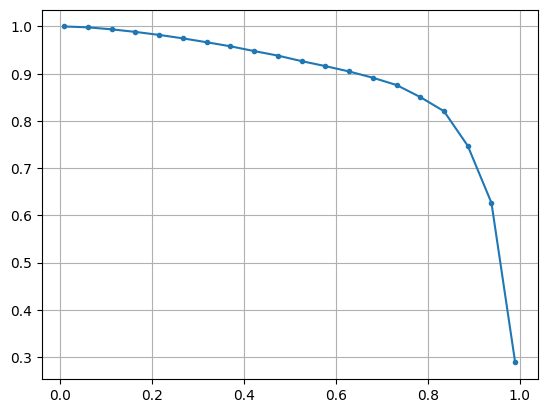

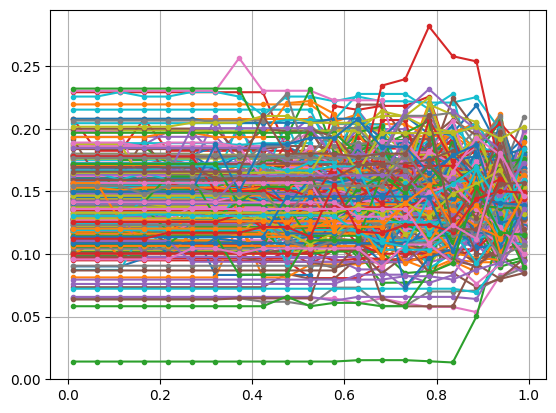

In [108]:
quantiles = np.linspace(.01, .99, 20)
acc, scores = [], []
for q in quantiles:
    cluster_centers = cluster_centers_orig.copy()
    for i in range(cluster_centers.shape[0]):
        ind = cluster_centers[i] < np.quantile(cluster_centers[i], q)
        cluster_centers[i, ind] *= 0
    km.cluster_centers_ = cluster_centers
    labels_ = km.predict(data)
    acc.append(np.mean(labels == labels_))
    distances = km.transform(data)
    data_train, data_test = get_mei_data(
        -distances, results['inputs']
    )
    scores.append(get_monosemanticity(data_train))
    print(q, scores[-1].mean(), acc[-1])
    km.cluster_centers_ = cluster_centers_orig.copy()
    
plt.plot(quantiles, acc, '.-')
plt.grid()
plt.show()

plt.plot(quantiles, scores, '.-')
plt.grid()
plt.show()

In [109]:
scores = np.array(scores)
scores.shape

(20, 257)

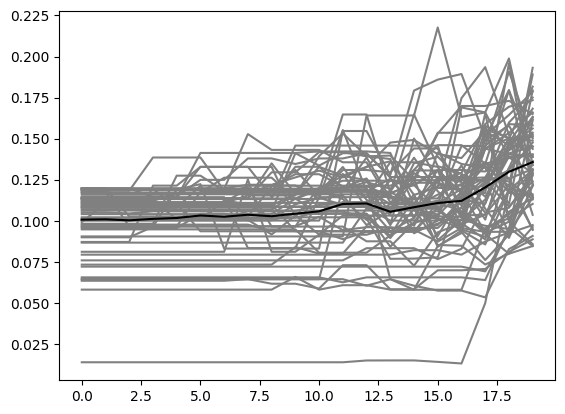

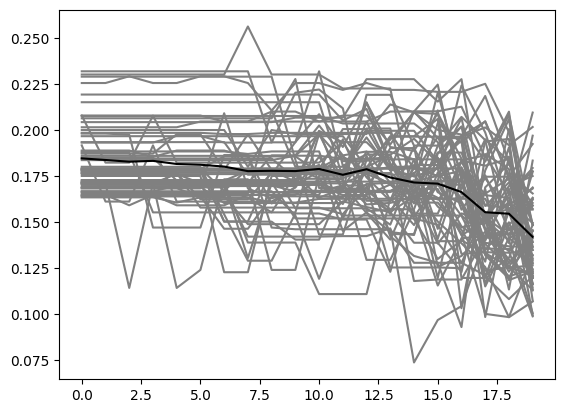

In [116]:
ind_mono = scores[0] < np.quantile(scores[0], .25)
plt.plot(scores[:, ind_mono], 'grey')
plt.plot(scores[:, ind_mono].mean(1), 'black')
plt.show()

ind_poly = scores[0] > np.quantile(scores[0], .75)
plt.plot(scores[:, ind_poly], 'grey')
plt.plot(scores[:, ind_poly].mean(1), 'black')
plt.show()